In [2]:
import geopandas as gpd
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.types import VARCHAR, Float, Integer,TIMESTAMP,JSON,Date
import numpy as np
from shapely import geos  
import fiona  
from fiona.crs import from_epsg,from_string
from shapely.geometry import Polygon, Point
from geopandas import GeoSeries
from pandas import Series,DataFrame
import pyproj
from datetime import datetime,timedelta
from matplotlib import pyplot as plt
from shapely.geometry import Point, LineString, shape,MultiLineString
#import networkx as nx
import osmnx as ox
import time
ox.config(log_console=True, use_cache=True)
import folium
import operator
import datetime
from collections import defaultdict
from functools import reduce
import networkx as nx
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import shapestats
from shapely import geometry
import geoplot as gplt


server_ip='140.137.37.194'
engine = create_engine('postgresql://postgres:Co43270131@%s:5432/hyxen' %(server_ip), use_batch_mode=True, pool_size=10, max_overflow=20)

In [ ]:
# 抓全部資料
sql='''
SELECT * 
FROM chi.taipei_allurser_50count_weekday_holiday
'''
taipei_allurser_weekdays_holiday=gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='geom' )


In [3]:
taipei_allurser_weekdays_holiday

,lon,ts,device_id,lat,geom,date_part,to_date
0,121.599800,2019-11-10 16:58:06,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975122,POINT (121.59980 23.97512),0.0,2019-11-10
1,121.599800,2019-11-10 16:58:06,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975122,POINT (121.59980 23.97512),0.0,2019-11-10
2,121.599749,2019-11-10 15:57:28,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (121.59975 23.97514),0.0,2019-11-10
3,121.599749,2019-11-10 15:57:27,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (121.59975 23.97514),0.0,2019-11-10
4,121.599749,2019-11-10 15:57:26,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (121.59975 23.97514),0.0,2019-11-10
...,...,...,...,...,...,...,...
19524404,121.623187,2019-11-10 19:54:18,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.998233,POINT (121.62319 23.99823),0.0,2019-11-10
19524405,121.623187,2019-11-10 19:54:17,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.998233,POINT (121.62319 23.99823),0.0,2019-11-10
19524406,121.599719,2019-11-10 17:13:33,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975156,POINT (121.59972 23.97516),0.0,2019-11-10
19524407,121.599721,2019-11-10 16:58:10,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975123,POINT (121.59972 23.97512),0.0,2019-11-10


Text(0, 0.5, 'ts')

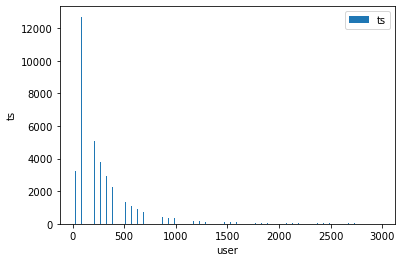

In [11]:
# 原始資料分布
# 使用者總共有幾筆資料
taipei_allurser=taipei_allurser_weekdays_holiday.groupby(["device_id"], as_index=False)['ts'].count().sort_values(['ts'], ascending=False).reset_index(drop=True)
#看原始資料分布
taipei_allurser= pd.DataFrame(taipei_allurser)
taipei_allurser.plot.hist(x='device_id',y='ts',bins=50 ,rwidth=0.1 , range=(0,3000))
plt.xlabel('user')
plt.ylabel('ts')

In [5]:
taipei_allurser

,device_id,ts
0,IJd95z5MbduN9R6/HBioIfscE1iuj+DzP2Cc96EHAt7dML...,476371
1,z+z4YSjp3lnDNTTwvAqe+VwiJxyJgonXp3O+Ls/1+NrLBr...,159508
2,uqTItKc7VlrqyqchT7NsGRsEGxA7JDV6vKqnzOBRpxUQfm...,121454
3,zUFnDsR8JR8xhK8HcGw8i4hsm4xYCaTWIDWqKmgxGfh83/...,120658
4,6Bogf8tMoYu+5+pfeDyE/f9lKIacrEhG1EhvEgFgAGXz/n...,74241
...,...,...
48227,5Z+qXynlMH/4Ak2mtlq17oHvFHB73s+zEr237rFY6WscKy...,50
48228,c3wMLAmEX8N+Yts8KDq9EWa7LbDJ1gYUesyd5v1OYq6l7k...,50
48229,5WkfC8o+wt3Ut+m4TIKLheb1MM88ZGMtJbPVLZSFoWAE/i...,50
48230,5UQ0Wvjp46ZjZfdzVRaneByZzfn4HEIUy0raO1G6c2KVrK...,50


## 一天有幾筆資料

In [15]:
def toDate(val):
    return val.date()
taipei_allurser_day=taipei_allurser_weekdays_holiday
taipei_allurser_day["日期"] = taipei_allurser_day['ts'].apply(toDate)
taipei_allurser_day

,lon,ts,device_id,lat,geom,date_part,to_date,日期
0,121.599800,2019-11-10 16:58:06,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975122,POINT (121.59980 23.97512),0.0,2019-11-10,2019-11-10
1,121.599800,2019-11-10 16:58:06,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975122,POINT (121.59980 23.97512),0.0,2019-11-10,2019-11-10
2,121.599749,2019-11-10 15:57:28,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (121.59975 23.97514),0.0,2019-11-10,2019-11-10
3,121.599749,2019-11-10 15:57:27,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (121.59975 23.97514),0.0,2019-11-10,2019-11-10
4,121.599749,2019-11-10 15:57:26,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (121.59975 23.97514),0.0,2019-11-10,2019-11-10
...,...,...,...,...,...,...,...,...
19524404,121.623187,2019-11-10 19:54:18,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.998233,POINT (121.62319 23.99823),0.0,2019-11-10,2019-11-10
19524405,121.623187,2019-11-10 19:54:17,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.998233,POINT (121.62319 23.99823),0.0,2019-11-10,2019-11-10
19524406,121.599719,2019-11-10 17:13:33,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975156,POINT (121.59972 23.97516),0.0,2019-11-10,2019-11-10
19524407,121.599721,2019-11-10 16:58:10,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975123,POINT (121.59972 23.97512),0.0,2019-11-10,2019-11-10


In [16]:
taipei_allurser_day

,lon,ts,device_id,lat,geom,date_part,to_date,日期
0,121.599800,2019-11-10 16:58:06,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975122,POINT (121.59980 23.97512),0.0,2019-11-10,2019-11-10
1,121.599800,2019-11-10 16:58:06,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975122,POINT (121.59980 23.97512),0.0,2019-11-10,2019-11-10
2,121.599749,2019-11-10 15:57:28,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (121.59975 23.97514),0.0,2019-11-10,2019-11-10
3,121.599749,2019-11-10 15:57:27,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (121.59975 23.97514),0.0,2019-11-10,2019-11-10
4,121.599749,2019-11-10 15:57:26,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (121.59975 23.97514),0.0,2019-11-10,2019-11-10
...,...,...,...,...,...,...,...,...
19524404,121.623187,2019-11-10 19:54:18,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.998233,POINT (121.62319 23.99823),0.0,2019-11-10,2019-11-10
19524405,121.623187,2019-11-10 19:54:17,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.998233,POINT (121.62319 23.99823),0.0,2019-11-10,2019-11-10
19524406,121.599719,2019-11-10 17:13:33,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975156,POINT (121.59972 23.97516),0.0,2019-11-10,2019-11-10
19524407,121.599721,2019-11-10 16:58:10,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975123,POINT (121.59972 23.97512),0.0,2019-11-10,2019-11-10


In [17]:
# 看一天有幾筆資料
oneuser_oneday=taipei_allurser_day.groupby(['日期', "device_id"], as_index=False).count().sort_values(['日期'], ascending=False).reset_index(drop=True)
oneuser_oneday

,日期,device_id,lon,ts,lat,geom,date_part,to_date
0,2020-09-29,zz6jUpr9x4a8QvJ6aQbnWaLMp8aD7xEPTnRvuxcvqy6dxM...,11,11,11,11,11,11
1,2020-09-29,J/IfWrsfvzZ/DTpuT5eo9gUtrK41AST/pa+7lM3LxbVKKR...,4,4,4,4,4,4
2,2020-09-29,J2gZNecuK38n4E27oz+e0EidjLxcg523WMxQjFjQZzLOW+...,6,6,6,6,6,6
3,2020-09-29,J2gOsi606xPMxhYLeQnMSYS9qgt2sWmj2RjoMT9+jhhU0s...,3,3,3,3,3,3
4,2020-09-29,J1jxDyzAmHqTF4atCjGN4HffCe948Lc3ATyYxxjoOvme1g...,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...
1477308,2019-10-01,e/vrHH7vuyuBZ0mLNcSvQRZV8edXFF2tpmMkCxfF06cSPv...,14,14,14,14,14,14
1477309,2019-10-01,e+fFFjwfHY+ie5Xz3SkPogSl+Pa2SWUpGH7UAytoPiN5QK...,18,18,18,18,18,18
1477310,2019-10-01,dzN+IC1VfvsKh+yY4pl6m+EKW+pHZB9cyvBmlDxnRUURMA...,5,5,5,5,5,5
1477311,2019-10-01,dyiTifVxVkETdoxvCH4yfujqWd5/9WzhkwCa1BLUJ6wKsR...,40,40,40,40,40,40


In [20]:
#整理dataframe，篩選特定欄位
oneuser_oneday = pd.DataFrame(oneuser_oneday)
oneuser_oneday=oneuser_oneday.rename(columns={'lon':'筆數'})
oneuser_oneday=oneuser_oneday.drop(['ts', 'lat', 'geom','date_part','to_date'], axis=1)
oneuser_oneday=oneuser_oneday.sort_values(by="device_id").reset_index(drop=True)
oneuser_oneday

,日期,device_id,筆數
0,2020-05-05,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,30
1,2020-04-23,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,22
2,2019-11-03,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,11
3,2020-04-21,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,11
4,2020-05-10,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,20
...,...,...,...
1477308,2019-11-19,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,15
1477309,2019-11-18,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,11
1477310,2020-03-07,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,3
1477311,2019-12-03,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,4


Text(0, 0.5, 'user')

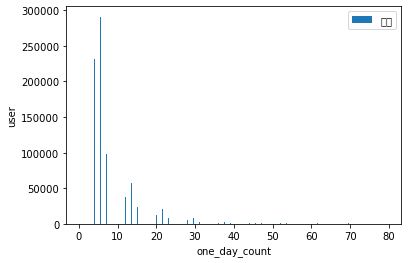

In [32]:
#展示
#fig, ax = plt.subplots()
#result.plot.line(legend=True)
oneuser_oneday.plot.hist(bins=50 ,rwidth=0.1 , range=(0,80))
plt.xlabel('one_day_count')
plt.ylabel('user')

## 平均一天幾筆

In [41]:
#oneuser_oneday['日期'] = result['日期'].replace(0, np.nan)
oneday_number=oneuser_oneday.groupby(["device_id"], as_index=False).mean()
oneday_number=oneday_number.rename(columns={'筆數':'count'})

oneday_number

,device_id,count
0,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,21.111111
1,++R665aDU9ttvk4SaoOjQ3IJqoTHAwWbWPxoSMPCOydXDT...,4.473684
2,++WorICj4CD1qqlQgPIarvnv72AFYbswRZiFQC66y6aK2J...,9.105263
3,++r+OWbk6fwIGo+XVhBWTmk+phKtCqsvLWzWazEakCdYmG...,7.370370
4,+/9bRQsybaZSKb80z+78KwnhgELd0iw6/8hsKGDPdWV1H/...,5.000000
...,...,...
48227,zzjZeFIQvqSv4ju7LMHZe0cxuAebEri5mgcBgmMD022J7F...,6.000000
48228,zzuM1NYYPCTN/SzFiUnSSS/Y+/zK7fc22PCQDpgvJlV7Dn...,5.777778
48229,zzzVFa7v11E7nXIZUBL6y9GOnaVh9LDhzeFRzUbGRG2MWn...,5.500000
48230,zzzlMCswbsIDCH4KrNmmFIihS0AQGOjmUbWl0R5jcKxCZi...,11.000000


Text(0, 0.5, 'urse')

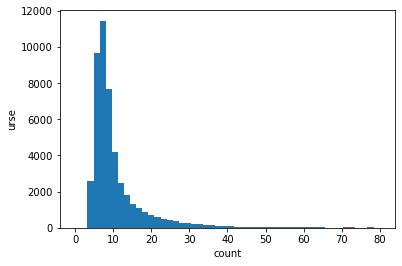

In [53]:
#Average day=平均一天幾筆軌跡點
oneday_number = pd.DataFrame(oneday_number)
#oneday_number.plot.hist(y='count',bins=50 ,rwidth=0.5 , range=(0,80))
fig,axes = plt.subplots()

oneday_number['count'].plot.hist(bins=50,ax=axes,range=(0,80))

plt.xlabel('count')
plt.ylabel('urse')

## 分平日假日

Weekday_holiday=taipei_allurser.to_crs(epsg=3826)
Weekday_holiday["week"]=Weekday_holiday["ts"].dt.dayofweek
#星期一=0,星期日=6
#假日=H,平日=W
week=[]
for i in Weekday_holiday['week']:
    if i==5:
        week.append('H')
    elif i==6:
        week.append('H')
    else:
        week.append('W')
Weekday_holiday['w']=week
#md 年月日 hd時分秒
md=Weekday_holiday["ts"].dt.strftime('%Y-%m-%d')
hm=Weekday_holiday["ts"].dt.strftime('%H:%M:%S')
Weekday_holiday['md']=md
Weekday_holiday['hm']=hm
#平日
#workday=Weekday_holiday[Weekday_holiday['w']=='W']
#workday=workday.reset_index(drop=True)
#workday

# <span style="color:red">建議寫法 by CCY</span>

In [54]:
# <span style="color:red">建議寫法 by CCY</span>
#星期一=0,星期日=6
#假日=H,平日=W

def check_WH_day(dayofweek):
    if dayofweek>=5:
        return('H')
    else:
        return('W')

taipei_allurser_weekdays_holiday=taipei_allurser_weekdays_holiday.to_crs(epsg=3826)
taipei_allurser_weekdays_holiday["week"] = taipei_allurser_weekdays_holiday["ts"].dt.dayofweek
taipei_allurser_weekdays_holiday['w'] = taipei_allurser_weekdays_holiday["week"].apply(check_WH_day)

#md 年月日 hd時分秒
md=taipei_allurser_weekdays_holiday["ts"].dt.strftime('%Y-%m-%d')
hm=taipei_allurser_weekdays_holiday["ts"].dt.strftime('%H:%M:%S')
taipei_allurser_weekdays_holiday['md']=md
taipei_allurser_weekdays_holiday['hm']=hm

In [55]:
taipei_allurser_weekdays_holiday

,lon,ts,device_id,lat,geom,date_part,to_date,日期,week,w,md,hm
0,121.599800,2019-11-10 16:58:06,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975122,POINT (311037.089 2652397.784),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,16:58:06
1,121.599800,2019-11-10 16:58:06,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975122,POINT (311037.089 2652397.784),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,16:58:06
2,121.599749,2019-11-10 15:57:28,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (311031.890 2652399.866),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,15:57:28
3,121.599749,2019-11-10 15:57:27,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (311031.890 2652399.866),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,15:57:27
4,121.599749,2019-11-10 15:57:26,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (311031.890 2652399.866),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,15:57:26
...,...,...,...,...,...,...,...,...,...,...,...,...
19524404,121.623187,2019-11-10 19:54:18,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.998233,POINT (313405.750 2654967.680),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,19:54:18
19524405,121.623187,2019-11-10 19:54:17,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.998233,POINT (313405.750 2654967.680),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,19:54:17
19524406,121.599719,2019-11-10 17:13:33,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975156,POINT (311028.830 2652401.514),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,17:13:33
19524407,121.599721,2019-11-10 16:58:10,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975123,POINT (311029.049 2652397.860),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,16:58:10


In [56]:
taipei_allurser_holiday=taipei_allurser_weekdays_holiday.loc[taipei_allurser_weekdays_holiday['w']=='H']
taipei_allurser_holiday

,lon,ts,device_id,lat,geom,date_part,to_date,日期,week,w,md,hm
0,121.599800,2019-11-10 16:58:06,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975122,POINT (311037.089 2652397.784),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,16:58:06
1,121.599800,2019-11-10 16:58:06,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975122,POINT (311037.089 2652397.784),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,16:58:06
2,121.599749,2019-11-10 15:57:28,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (311031.890 2652399.866),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,15:57:28
3,121.599749,2019-11-10 15:57:27,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (311031.890 2652399.866),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,15:57:27
4,121.599749,2019-11-10 15:57:26,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975141,POINT (311031.890 2652399.866),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,15:57:26
...,...,...,...,...,...,...,...,...,...,...,...,...
19524404,121.623187,2019-11-10 19:54:18,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.998233,POINT (313405.750 2654967.680),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,19:54:18
19524405,121.623187,2019-11-10 19:54:17,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.998233,POINT (313405.750 2654967.680),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,19:54:17
19524406,121.599719,2019-11-10 17:13:33,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975156,POINT (311028.830 2652401.514),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,17:13:33
19524407,121.599721,2019-11-10 16:58:10,vfp9N1D8hTRmoAKxkj6B1X8DXATRjOVE7deRlwvqlTfn4Z...,23.975123,POINT (311029.049 2652397.860),0.0,2019-11-10,2019-11-10,6,H,2019-11-10,16:58:10


In [57]:
taipei_allurser_weekdays=taipei_allurser_weekdays_holiday.loc[taipei_allurser_weekdays_holiday['w']=='W']
taipei_allurser_weekdays

,lon,ts,device_id,lat,geom,date_part,to_date,日期,week,w,md,hm
110246,121.491625,2019-11-06 19:03:52,NDxlr4Nq9j/FlXsPuSSOS+b0cyyHv21iHzUKXNl+bKgHfB...,25.081081,POINT (299592.381 2774848.492),3.0,2019-11-06,2019-11-06,2,W,2019-11-06,19:03:52
110247,121.491625,2019-11-06 13:20:23,NDxlr4Nq9j/FlXsPuSSOS+b0cyyHv21iHzUKXNl+bKgHfB...,25.081081,POINT (299592.381 2774848.492),3.0,2019-11-06,2019-11-06,2,W,2019-11-06,13:20:23
110248,121.491625,2019-11-06 11:37:31,NDxlr4Nq9j/FlXsPuSSOS+b0cyyHv21iHzUKXNl+bKgHfB...,25.081081,POINT (299592.381 2774848.492),3.0,2019-11-06,2019-11-06,2,W,2019-11-06,11:37:31
110249,121.491625,2019-11-06 11:36:30,NDxlr4Nq9j/FlXsPuSSOS+b0cyyHv21iHzUKXNl+bKgHfB...,25.081081,POINT (299592.381 2774848.492),3.0,2019-11-06,2019-11-06,2,W,2019-11-06,11:36:30
110250,121.491625,2019-11-06 11:36:30,NDxlr4Nq9j/FlXsPuSSOS+b0cyyHv21iHzUKXNl+bKgHfB...,25.081081,POINT (299592.381 2774848.492),3.0,2019-11-06,2019-11-06,2,W,2019-11-06,11:36:30
...,...,...,...,...,...,...,...,...,...,...,...,...
19520025,121.518788,2019-11-04 13:58:05,m7nX+nKnqt5zziGhYVnkQESVlE19asFuLF8+0CB8no4L3L...,25.003438,POINT (302365.464 2766258.569),1.0,2019-11-04,2019-11-04,0,W,2019-11-04,13:58:05
19520026,121.542625,2019-11-04 18:43:35,5hyPyTCGCSR+AD6ufXhcVcdtyD0YigxrO95C+ax1uXiInQ...,24.996773,POINT (304774.515 2765529.774),1.0,2019-11-04,2019-11-04,0,W,2019-11-04,18:43:35
19520027,121.527090,2019-11-04 16:00:46,5hyPyTCGCSR+AD6ufXhcVcdtyD0YigxrO95C+ax1uXiInQ...,25.144354,POINT (303142.593 2781870.550),1.0,2019-11-04,2019-11-04,0,W,2019-11-04,16:00:46
19520028,121.518041,2019-11-04 12:40:05,5hyPyTCGCSR+AD6ufXhcVcdtyD0YigxrO95C+ax1uXiInQ...,25.119199,POINT (302240.923 2779080.578),1.0,2019-11-04,2019-11-04,0,W,2019-11-04,12:40:05


## 平日使用者分析

In [3]:
sql='''
SELECT * 
FROM chi.taipei_allurser_50count_weekdays
'''
taipei_allurser_weekdays=gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='geom' )

In [4]:
taipei_allurser_weekdays

,lon,ts,device_id,lat,geom,date_part
0,121.487231,2020-03-20 14:33:56,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008934,POINT (121.48723 25.00893),5.0
1,121.487233,2020-03-20 15:03:54,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008934,POINT (121.48723 25.00893),5.0
2,121.487246,2020-03-20 15:38:05,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008938,POINT (121.48725 25.00894),5.0
3,121.487365,2020-03-20 16:16:38,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.009100,POINT (121.48737 25.00910),5.0
4,121.487249,2020-03-20 16:34:39,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.009091,POINT (121.48725 25.00909),5.0
...,...,...,...,...,...,...
11795887,121.487212,2020-03-20 09:18:19,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008919,POINT (121.48721 25.00892),5.0
11795888,121.487244,2020-03-20 10:35:47,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008946,POINT (121.48724 25.00895),5.0
11795889,121.487222,2020-03-20 13:11:19,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008938,POINT (121.48722 25.00894),5.0
11795890,121.487221,2020-03-20 13:33:58,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008937,POINT (121.48722 25.00894),5.0


In [5]:
sql='''
SELECT * 
FROM chi."Socio_economic_database_POI"
'''
Socio_economic_database_POI=gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='geom' )

In [6]:
Socio_economic_database_POI

,CODEBASE,TOWN,COUNTY,醫療院所家數,老人安養機構家數,社區照顧關懷據點家數,兒童福利服務機構家數,婦幼福利服務機構家數,老人安養、養護、長期照護機構家數,居家服務支援中心家數,...,不動產業,專業、科學及技術服務業,支援服務業,公共行政及國防；強制性社會安全,教育服務業,醫療保健及社會工作服務業,藝術、娛樂及休閒服務業,其他服務業,資料時間,geom
0,A6803-0620-00,大溪區,桃園市,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,108Y,"POLYGON ((121.31318 24.83198, 121.31369 24.831..."
1,A6803-0621-00,大溪區,桃園市,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,108Y,"POLYGON ((121.25816 24.83229, 121.25855 24.831..."
2,A6803-0622-00,大溪區,桃園市,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,108Y,"POLYGON ((121.26890 24.82930, 121.26891 24.828..."
3,A6803-0625-00,大溪區,桃園市,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,108Y,"POLYGON ((121.31082 24.82770, 121.31104 24.827..."
4,A6803-0623-00,大溪區,桃園市,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,108Y,"POLYGON ((121.29515 24.83016, 121.29740 24.828..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157928,A6803-0613-00,大溪區,桃園市,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,108Y,"POLYGON ((121.33065 24.83215, 121.33085 24.832..."
157929,A6803-0617-00,大溪區,桃園市,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,108Y,"POLYGON ((121.26737 24.84840, 121.26795 24.848..."
157930,A6803-0618-00,大溪區,桃園市,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,108Y,"POLYGON ((121.26614 24.83190, 121.26603 24.831..."
157931,A6803-0619-00,大溪區,桃園市,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,108Y,"POLYGON ((121.29937 24.83162, 121.29944 24.831..."


In [9]:
sjoined_listings = gpd.sjoin(taipei_allurser_weekdays,Socio_economic_database_POI)
sjoined_listings

KeyboardInterrupt: 

from geoalchemy2 import Geometry,WKTElement
#server_ip='140.137.37.194'
#engine = create_engine('postgresql://postgres:Co43270131@%s:5432/hyxen' %(server_ip), use_batch_mode=True)
Weekday_holiday['geometry'] = Weekday_holiday['geom'].apply(lambda x: WKTElement(x.wkt, srid=3826))
Weekday_holiday.drop('geometry',1,inplace=True)

Weekday_holiday

## 迴轉半徑(平日/假日使用者)

In [ ]:
#平日
taipei_allurser_weekdays["x"] = taipei_allurser_weekdays.centroid.x
taipei_allurser_weekdays["y"] = taipei_allurser_weekdays.centroid.y
#taipei_allurser_weekdays["日期"] = taipei_allurser_weekdays['ts'].apply(toDate)
taipei_allurser_weekdays=taipei_allurser_weekdays.reset_index(drop=True)
taipei_allurser_weekdays

In [ ]:
taipei_allurser_weekdays_drop=taipei_allurser_weekdays.drop(columns=['lon', 'lat','geom','ts'])

In [ ]:
taipei_allurser_weekdays_drop=taipei_allurser_weekdays_drop.drop_duplicates(inplace=False)#刪重複#原來有11795892筆
taipei_allurser_weekdays_drop

In [ ]:
def shapestats_area(df):
    if len(df)>2:
        _df=df[['x','y']].values.tolist()
        shape = geometry.Polygon(_df).simplify(0)
        try:
            area=shapestats.maxbc.maximum_contained_circle(shape).area
        except:
            area=0
        return area
taipei_allurser_groupby=taipei_allurser_weekdays_drop.groupby(['device_id','日期']).apply(shapestats_area)
#taipei_allurser_groupby=taipei_allurser_weekdays_drop.groupby(['device_id','日期'])
taipei_allurser_groupby

In [ ]:
taipei_allurser_groupby=taipei_allurser_groupby.add_suffix('').reset_index()
taipei_allurser_groupby=taipei_allurser_groupby.replace(0,np.NaN)


In [ ]:
taipei_allurser_groupby_maen=taipei_allurser_groupby.groupby('device_id').mean()
#plt.plot(taipei_allurser_groupby_maen.device_id, taipei_allurser_groupby_maen.PTS, color='b')
taipei_allurser_groupby_maen=taipei_allurser_groupby_maen.add_suffix('').reset_index()
taipei_allurser_groupby_maen=taipei_allurser_groupby_maen.rename(columns={'0':'mean'})
taipei_allurser_groupby_maen=taipei_allurser_groupby_maen.replace(np.NaN,0)

taipei_allurser_groupby_maen

## 時間間隔(早、中、晚都有資料)

In [44]:
#早= 0:00-8:00
name_list=[]
df=pd.DataFrame(columns = ["device_id","md","hm"]) #建立一個空的dataframe
user_oneday_time=pd.DataFrame(columns = ["device_id","md","hm"]) #建立一個空的dataframe
morning=pd.DataFrame(columns = ["device_id","md","hm"]) #建立一個空的dataframe

one_user=Weekday_holiday.groupby(["device_id"], as_index=False) 
for name, group in one_user:
    print(one_user)
    name_list.append(name) 
    #for index,row in Weekday_holiday.iterrows():
        #if row['device_id'] == name :
            #print(row['device_id'])
            #print(row['device_id'])
            #一個使用者完整資料
            #oneuser_df=df.append({'device_id' : row['device_id'] , 'md' :  row['md'], 'hm' : row['hm']} , ignore_index=True)
            #一個使用者的單一個日期
            #time_list=[]
            #one_user_time=oneuser_df.groupby(["md"], as_index=False)
            #for time, group in one_user_time:
                #time_list.append(time) 
                #for _index,_row in oneuser_df.iterrows():
                    #if row['md'] == time :
                        # 一個使用者一個日期鐘的時間有哪些
                        #user_oneday_time=user_oneday_time.append({'device_id' : row['device_id'],'md':row['md'],'hm':row['hm']},ignore_index=True)
                        #if len(user_oneday_time[user_oneday_time['hm'].between('00:00:00','08:00:00')])>0:
                            #morning=df.append({'device_id' : row['device_id'] ,'md':row['md'],'hm':row['hm']},ignore_index=True)
    #break

MemoryError: Unable to allocate 149. MiB for an array with shape (19524409,) and data type int64

### 所有user_id的列表

In [61]:
one_user = Weekday_holiday['device_id'].unique()
one_user

array(['ZEtIbJ9QoV5yjhOWBHg16JyQ4ZWunQXWZIhW2CrmEi98WKzePKYrT9lx25FrJMrj',
       'XLykcgb1zzhoyvGKx0XanfIOIoxI8NvbQtu00ZIYRYuiTU26FpEDLRzovVHdROyk',
       '0cPGD51uLPOx8L6Gt++Q0+tgVdfXfZIddaLc0J4iXR9FiMJlph5BedcsNWlD/PCr',
       ...,
       '+5qV+pils/PMJHqTDC16h6vjmYzKLOphupcjmox3Cu2vBXqC8nBieIxS+R1r1cqg',
       'uLZvbM6gs8lhemjzk3aXHtBoZJhPanXrVRpP3uE+xXu3K/He+ddVlAfzllcM0YVL',
       'IS+tCH2vik4GWhBCvCcWlD6YWINChreGHRuJA5cuLdGqsutM/wrR0Y949avDDxs0'],
      dtype=object)

### 早上user_id的列表

In [ ]:
time_interval_Morning=taipei_Shapestats_workday[taipei_Shapestats_workday['hm'].between('00:00:00','08:00:00')].sort_values(['ts'], ascending=False).reset_index(drop=True)
morning_user = time_interval_Morning['device_id'].unique()

    

----------------------------------------

In [ ]:
df=pd.DataFrame(columns = ["device_id","hm"]) #建立一個空的dataframe


In [28]:
#早= 0:00-8:00
name_list=[]
df=pd.DataFrame(columns = ["device_id","hm"]) #建立一個空的dataframe
time_interval_Morning=taipei_Shapestats_workday[taipei_Shapestats_workday['hm'].between('00:00:00','08:00:00')].sort_values(['ts'], ascending=False).reset_index(drop=True)
#time_interval_Morning = taipei_Shapestats_workday[(taipei_Shapestats_workday['hm'] >=pd.to_datetime('00:00:00')) & (taipei_Shapestats_workday['hm'] <= pd.to_datetime('00:08:00'))]
time_interval_Morning
time_interval_Morning_name=time_interval_Morning.groupby('device_id')
for Morning_name, group in time_interval_Morning_name:
    name_list.append(Morning_name)
    #print(name_list)
    for index,row in taipei_Shapestats_workday.iterrows():
        if row['device_id'] == Morning_name :
            #print(row['device_id'])
            print(row['device_id'])
            df=df.append({'device_id' : row['device_id'] , 'hm' :  row['hm']} , ignore_index=True)

+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1B8nZg53S/SwJytr8hP
+Qu3aDlV/dWpirf0LZ8o8IS18

In [29]:
#中= 8:00-16:00
name_list=[]
df2=pd.DataFrame(columns = ["device_id","hm"]) #建立一個空的dataframe
time_interval_noon=df[df['hm'].between('08:00:00','16:00:00')].reset_index(drop=True)
time_interval_noon
#time_interval_noon
time_interval_noon_name=time_interval_noon.groupby('device_id')
for noon_name, group in time_interval_noon_name:
    name_list.append(noon_name)
    #print(name_list)
    for index,row in taipei_Shapestats_workday.iterrows():
        if row['device_id'] == noon_name :
            #print(row['device_id'])
            #print(Morning_name)
            df2=df2.append({'device_id' : row['device_id'] , 'hm' :  row['hm']} , ignore_index=True)
print(df2)

                                              device_id        hm
0     +Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1...  07:37:44
1     +Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1...  07:37:46
2     +Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1...  07:37:46
3     +Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1...  13:07:42
4     +Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1...  13:07:57
...                                                 ...       ...
7902  zxeJywLOnE4N/u8OfukU7nkbxqeb9lK+rQZgFO0LGKBB1l...  07:46:13
7903  zxeJywLOnE4N/u8OfukU7nkbxqeb9lK+rQZgFO0LGKBB1l...  07:47:50
7904  zxeJywLOnE4N/u8OfukU7nkbxqeb9lK+rQZgFO0LGKBB1l...  07:48:10
7905  zxeJywLOnE4N/u8OfukU7nkbxqeb9lK+rQZgFO0LGKBB1l...  12:48:17
7906  zxeJywLOnE4N/u8OfukU7nkbxqeb9lK+rQZgFO0LGKBB1l...  13:08:49

[7907 rows x 2 columns]


In [30]:
#晚= 16:00-24:00
name_list=[]
df3=pd.DataFrame(columns = ["device_id","hm"]) #建立一個空的dataframe
time_interval_night=df2[df2['hm'].between('16:00:00','23:59:59')].reset_index(drop=True)
time_interval_night
#time_interval_noon
time_interval_night_name=time_interval_night.groupby('device_id')
for night_name, group in time_interval_night_name:
    name_list.append(night_name)
    #print(name_list)
    for index,row in taipei_Shapestats_workday.iterrows():
        if row['device_id'] == night_name :
            #print(row['device_id'])
            #print(Morning_name)
            df3=df3.append({'device_id' : row['device_id'] , 'hm' :  row['hm']} , ignore_index=True)
print(df3)

                                              device_id        hm
0     +Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1...  07:37:44
1     +Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1...  07:37:46
2     +Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1...  07:37:46
3     +Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1...  13:07:42
4     +Qu3aDlV/dWpirf0LZ8o8IS18jheRWtEW+5zKshYjqfZi1...  13:07:57
...                                                 ...       ...
6995  zplX1RfXKVGWhAel40FRbibXMX4kxM5ntJpyHxf56VK1FA...  20:08:20
6996  zplX1RfXKVGWhAel40FRbibXMX4kxM5ntJpyHxf56VK1FA...  20:18:02
6997  zplX1RfXKVGWhAel40FRbibXMX4kxM5ntJpyHxf56VK1FA...  21:28:02
6998  zplX1RfXKVGWhAel40FRbibXMX4kxM5ntJpyHxf56VK1FA...  21:28:07
6999  zplX1RfXKVGWhAel40FRbibXMX4kxM5ntJpyHxf56VK1FA...  21:36:56

[7000 rows x 2 columns]


In [34]:
len(name_list)

157

## 使用者活動時間

In [10]:
sql='''
SELECT * FROM chi.taipei_allurser_time
ORDER BY device_id,ts ASC
'''
taipei_Activity_time=pd.read_sql_query(sql,con=engine)

KeyboardInterrupt: 

In [3]:
taipei_Activity_time

,device_id,ts,to_date,hour,minute,second,total_second
0,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01 17:02:57,2019-11-01,17.0,2.0,57.0,61377.0
1,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01 20:58:16,2019-11-01,20.0,58.0,16.0,75496.0
2,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01 20:58:16,2019-11-01,20.0,58.0,16.0,75496.0
3,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01 20:58:22,2019-11-01,20.0,58.0,22.0,75502.0
4,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01 23:22:59,2019-11-01,23.0,22.0,59.0,84179.0
...,...,...,...,...,...,...,...
19524404,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-21 20:20:38,2019-12-21,20.0,20.0,38.0,73238.0
19524405,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-21 23:16:20,2019-12-21,23.0,16.0,20.0,83780.0
19524406,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2020-03-07 15:07:03,2020-03-07,15.0,7.0,3.0,54423.0
19524407,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2020-03-07 16:00:17,2020-03-07,16.0,0.0,17.0,57617.0


In [33]:
#taipei_Activity_time=taipei_Activity_time.drop(['diff'], axis=1) #欄位刪除
taipei_Activity_time['diff']=taipei_Activity_time.sort_values(['device_id','ts','to_date']).groupby(['device_id','to_date'])['total_second'].diff()
taipei_Activity_time

,device_id,ts,to_date,hour,minute,second,total_second,diff
0,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01 17:02:57,2019-11-01,17.0,2.0,57.0,61377.0,NaN
1,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01 20:58:16,2019-11-01,20.0,58.0,16.0,75496.0,14119.0
2,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01 20:58:16,2019-11-01,20.0,58.0,16.0,75496.0,0.0
3,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01 20:58:22,2019-11-01,20.0,58.0,22.0,75502.0,6.0
4,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01 23:22:59,2019-11-01,23.0,22.0,59.0,84179.0,8677.0
...,...,...,...,...,...,...,...,...
19524404,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-21 20:20:38,2019-12-21,20.0,20.0,38.0,73238.0,971.0
19524405,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-21 23:16:20,2019-12-21,23.0,16.0,20.0,83780.0,10542.0
19524406,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2020-03-07 15:07:03,2020-03-07,15.0,7.0,3.0,54423.0,NaN
19524407,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2020-03-07 16:00:17,2020-03-07,16.0,0.0,17.0,57617.0,3194.0


In [42]:
taipei_Activity_time_mean=taipei_Activity_time[['device_id','to_date','diff']]
taipei_Activity_time_mean=taipei_Activity_time_mean.replace(0,np.NaN)
taipei_Activity_time_mean

,device_id,to_date,diff
0,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01,NaN
1,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01,14119.0
2,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01,NaN
3,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01,6.0
4,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01,8677.0
...,...,...,...
19524404,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-21,971.0
19524405,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-21,10542.0
19524406,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2020-03-07,NaN
19524407,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2020-03-07,3194.0


In [43]:
taipei_Activity_time_mean=taipei_Activity_time_mean.groupby(['device_id','to_date']).mean()
taipei_Activity_time_mean
#taipei_Activity_time.apply()

diff
device_id                                          to_date                 
++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlrY... 2019-11-01   5701.250000
                                                   2019-11-02   7823.250000
                                                   2019-11-03   3922.166667
                                                   2019-11-04      3.666667
                                                   2019-11-06   2773.833333
...                                                                     ...
zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDUl... 2019-11-29  29773.500000
                                                   2019-12-01   1769.285714
                                                   2019-12-03   1950.000000
                                                   2019-12-21   5582.000000
                                                   2020-03-07   1945.000000

[1477313 rows x 1 columns]

In [46]:
 taipei_Activity_time_mean=taipei_Activity_time_mean.add_suffix('_Count').reset_index()

In [47]:
taipei_Activity_time_mean

,device_id,to_date,diff_Count
0,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01,5701.250000
1,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-02,7823.250000
2,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-03,3922.166667
3,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-04,3.666667
4,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-06,2773.833333
...,...,...,...
1477308,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-11-29,29773.500000
1477309,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-01,1769.285714
1477310,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-03,1950.000000
1477311,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-21,5582.000000


In [52]:
# 計算個數
taipei_Activity_time_count=taipei_Activity_time[['device_id','to_date','ts']]
taipei_Activity_time_count=taipei_Activity_time_count.groupby(['device_id','to_date']).count()
taipei_Activity_time_count=taipei_Activity_time_count.add_suffix('_Count').reset_index()
taipei_Activity_time_count

,device_id,to_date,ts_Count
0,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01,6
1,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-02,6
2,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-03,11
3,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-04,5
4,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-06,8
...,...,...,...
1477308,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-11-29,3
1477309,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-01,27
1477310,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-03,4
1477311,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-21,5


In [54]:
taipei_Activity=pd.merge(taipei_Activity_time_count, taipei_Activity_time_mean)
taipei_Activity

,device_id,to_date,ts_Count,diff_Count
0,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01,6,5701.250000
1,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-02,6,7823.250000
2,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-03,11,3922.166667
3,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-04,5,3.666667
4,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-06,8,2773.833333
...,...,...,...,...
1477308,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-11-29,3,29773.500000
1477309,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-01,27,1769.285714
1477310,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-03,4,1950.000000
1477311,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-12-21,5,5582.000000


---------------------------------------------------------------

## 活動範圍

In [2]:
sql='''
SELECT * 
FROM chi.taipei_allurser_50count_weekdays
'''
taipei_allurser_weekdays=gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='geom' )
#limit 100

In [60]:
taipei_allurser_weekdays

,lon,ts,device_id,lat,geom,date_part,x,y,日期
0,121.487231,2020-03-20 14:33:56,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008934,POINT (299177.921 2766855.521),5.0,299177.921456,2.766856e+06,2020-03-20
1,121.487233,2020-03-20 15:03:54,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008934,POINT (299178.123 2766855.500),5.0,299178.123405,2.766856e+06,2020-03-20
2,121.487246,2020-03-20 15:38:05,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008938,POINT (299179.404 2766855.970),5.0,299179.403608,2.766856e+06,2020-03-20
3,121.487365,2020-03-20 16:16:38,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.009100,POINT (299191.421 2766873.968),5.0,299191.420965,2.766874e+06,2020-03-20
4,121.487249,2020-03-20 16:34:39,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.009091,POINT (299179.676 2766872.918),5.0,299179.675764,2.766873e+06,2020-03-20
...,...,...,...,...,...,...,...,...,...
11795887,121.487212,2020-03-20 09:18:19,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008919,POINT (299175.969 2766853.831),5.0,299175.969368,2.766854e+06,2020-03-20
11795888,121.487244,2020-03-20 10:35:47,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008946,POINT (299179.239 2766856.833),5.0,299179.239006,2.766857e+06,2020-03-20
11795889,121.487222,2020-03-20 13:11:19,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008938,POINT (299177.042 2766855.972),5.0,299177.041688,2.766856e+06,2020-03-20
11795890,121.487221,2020-03-20 13:33:58,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008937,POINT (299176.901 2766855.883),5.0,299176.900697,2.766856e+06,2020-03-20


In [4]:
def toDate(val):
    return val.date()

In [5]:
#taipei_allurser_weekdays.crs
taipei_allurser_weekdays=taipei_allurser_weekdays.to_crs(epsg=3826)

In [6]:
taipei_allurser_weekdays["x"] = taipei_allurser_weekdays.centroid.x
taipei_allurser_weekdays["y"] = taipei_allurser_weekdays.centroid.y
taipei_allurser_weekdays["日期"] = taipei_allurser_weekdays['ts'].apply(toDate)
taipei_allurser_weekdays=taipei_allurser_weekdays.reset_index(drop=True)
taipei_allurser_weekdays

,lon,ts,device_id,lat,geom,date_part,x,y,日期
0,121.487231,2020-03-20 14:33:56,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008934,POINT (299177.921 2766855.521),5.0,299177.921456,2.766856e+06,2020-03-20
1,121.487233,2020-03-20 15:03:54,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008934,POINT (299178.123 2766855.500),5.0,299178.123405,2.766856e+06,2020-03-20
2,121.487246,2020-03-20 15:38:05,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008938,POINT (299179.404 2766855.970),5.0,299179.403608,2.766856e+06,2020-03-20
3,121.487365,2020-03-20 16:16:38,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.009100,POINT (299191.421 2766873.968),5.0,299191.420965,2.766874e+06,2020-03-20
4,121.487249,2020-03-20 16:34:39,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.009091,POINT (299179.676 2766872.918),5.0,299179.675764,2.766873e+06,2020-03-20
...,...,...,...,...,...,...,...,...,...
11795887,121.487212,2020-03-20 09:18:19,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008919,POINT (299175.969 2766853.831),5.0,299175.969368,2.766854e+06,2020-03-20
11795888,121.487244,2020-03-20 10:35:47,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008946,POINT (299179.239 2766856.833),5.0,299179.239006,2.766857e+06,2020-03-20
11795889,121.487222,2020-03-20 13:11:19,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008938,POINT (299177.042 2766855.972),5.0,299177.041688,2.766856e+06,2020-03-20
11795890,121.487221,2020-03-20 13:33:58,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,25.008937,POINT (299176.901 2766855.883),5.0,299176.900697,2.766856e+06,2020-03-20


In [7]:
taipei_allurser_weekdays.crs

<Projected CRS: EPSG:3826>
Name: TWD97 / TM2 zone 121
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Taiwan - 120°E to 122°E
- bounds: (119.99, 20.41, 122.06, 26.72)
Coordinate Operation:
- name: Taiwan 2-degree TM zone 121
- method: Transverse Mercator
Datum: Taiwan Datum 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
taipei_allurser_weekdays_drop=taipei_allurser_weekdays.drop(columns=['lon', 'lat','geom','ts'])

In [9]:
taipei_allurser_weekdays_drop

,device_id,date_part,x,y,日期
0,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299177.921456,2.766856e+06,2020-03-20
1,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299178.123405,2.766856e+06,2020-03-20
2,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299179.403608,2.766856e+06,2020-03-20
3,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299191.420965,2.766874e+06,2020-03-20
4,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299179.675764,2.766873e+06,2020-03-20
...,...,...,...,...,...
11795887,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299175.969368,2.766854e+06,2020-03-20
11795888,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299179.239006,2.766857e+06,2020-03-20
11795889,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299177.041688,2.766856e+06,2020-03-20
11795890,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299176.900697,2.766856e+06,2020-03-20


In [10]:
taipei_allurser_weekdays_drop=taipei_allurser_weekdays_drop.drop_duplicates(inplace=False)#刪重複#原來有11795892筆
taipei_allurser_weekdays_drop

,device_id,date_part,x,y,日期
0,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299177.921456,2.766856e+06,2020-03-20
1,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299178.123405,2.766856e+06,2020-03-20
2,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299179.403608,2.766856e+06,2020-03-20
3,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299191.420965,2.766874e+06,2020-03-20
4,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299179.675764,2.766873e+06,2020-03-20
...,...,...,...,...,...
11795887,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299175.969368,2.766854e+06,2020-03-20
11795888,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299179.239006,2.766857e+06,2020-03-20
11795889,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299177.041688,2.766856e+06,2020-03-20
11795890,ENSH+80Hz5IPi5EzuHIOM2qfPW2Qta5ThMPI6ZgJ3zMnDg...,5.0,299176.900697,2.766856e+06,2020-03-20


taipei_allurser_groupby=taipei_allurser_weekdays_drop.groupby(['device_id','日期'])


shapestats_area=gpd.GeoDataFrame(columns = ["device_id","time","shapestats_area","count"],crs="EPSG:3826")

for _id,_group in taipei_allurser_groupby:

    if len(_group)>2:
        _df=_group[['x','y']].values.tolist()#要篩出兩個欄位就好
        #print(_df)
        shape = geometry.Polygon(_df).simplify(0)#.exterior.coords
        try: 
            shapestats_area=shapestats_area.append({'device_id':_id[0],'time':_id[1],
                               'shapestats_area' :shapestats.maxbc.maximum_contained_circle(shape).area,
                                'count':len(_group)},ignore_index=True)
        except:
            shapestats_area=shapestats_area.append({'device_id':_id[0],'time':_id[1],
                               'shapestats_area' :0,
                                'count':len(_group)},ignore_index=True)
        #print(shapestats.maxbc.maximum_contained_circle(shape).area)    
        #break

In [11]:
#shapestats_area
def shapestats_area(df):
    if len(df)>2:
        _df=df[['x','y']].values.tolist()
        shape = geometry.Polygon(_df).simplify(0)
        try:
            area=shapestats.maxbc.maximum_contained_circle(shape).area
        except:
            area=0
        return area
taipei_allurser_groupby=taipei_allurser_weekdays_drop.groupby(['device_id','日期']).apply(shapestats_area)
#taipei_allurser_groupby=taipei_allurser_weekdays_drop.groupby(['device_id','日期'])
taipei_allurser_groupby

device_id                                                         日期        
++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlrYyMQbaxvNJYOBCuWHg  2019-11-01    0.000000e+00
                                                                  2019-11-04             NaN
                                                                  2019-11-06    0.000000e+00
                                                                  2019-11-08    1.204676e+01
                                                                  2019-11-13    3.711197e+06
                                                                                    ...     
zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDUlMO1DPGP8oyZL7tadP  2019-11-18    0.000000e+00
                                                                  2019-11-19    9.374852e-02
                                                                  2019-11-26    7.783742e-01
                                                                  2019-11-29    0.0000

In [12]:
taipei_allurser_groupby=taipei_allurser_groupby.add_suffix('').reset_index()
taipei_allurser_groupby=taipei_allurser_groupby.replace(0,np.NaN)

#taipei_allurser_groupby.groupby('device_id')

In [13]:
taipei_allurser_groupby

,device_id,日期,0
0,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-01,NaN
1,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-04,NaN
2,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-06,NaN
3,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-08,1.204676e+01
4,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,2019-11-13,3.711197e+06
...,...,...,...
1004933,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-11-18,NaN
1004934,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-11-19,9.374852e-02
1004935,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-11-26,7.783742e-01
1004936,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...,2019-11-29,NaN


In [14]:
taipei_allurser_groupby_maen=taipei_allurser_groupby.groupby('device_id').mean()
#plt.plot(taipei_allurser_groupby_maen.device_id, taipei_allurser_groupby_maen.PTS, color='b')
taipei_allurser_groupby_maen=taipei_allurser_groupby_maen.add_suffix('').reset_index()
taipei_allurser_groupby_maen=taipei_allurser_groupby_maen.rename(columns={'0':'mean'})
taipei_allurser_groupby_maen=taipei_allurser_groupby_maen.replace(np.NaN,0)

taipei_allurser_groupby_maen

,device_id,mean
0,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,413464.348867
1,++R665aDU9ttvk4SaoOjQ3IJqoTHAwWbWPxoSMPCOydXDT...,0.008089
2,++WorICj4CD1qqlQgPIarvnv72AFYbswRZiFQC66y6aK2J...,214531.184053
3,++r+OWbk6fwIGo+XVhBWTmk+phKtCqsvLWzWazEakCdYmG...,127.821108
4,+/9bRQsybaZSKb80z+78KwnhgELd0iw6/8hsKGDPdWV1H/...,29552.802999
...,...,...
48121,zzjZeFIQvqSv4ju7LMHZe0cxuAebEri5mgcBgmMD022J7F...,10610.259343
48122,zzuM1NYYPCTN/SzFiUnSSS/Y+/zK7fc22PCQDpgvJlV7Dn...,NaN
48123,zzzVFa7v11E7nXIZUBL6y9GOnaVh9LDhzeFRzUbGRG2MWn...,23616.041944
48124,zzzlMCswbsIDCH4KrNmmFIihS0AQGOjmUbWl0R5jcKxCZi...,5459.025765


In [46]:
#taipei_allurser_groupby_maen['mean'].plot()
#taipei_allurser_groupby_maen
taipei_allurser_groupby_maen

,device_id,mean
0,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,413464.348867
1,++R665aDU9ttvk4SaoOjQ3IJqoTHAwWbWPxoSMPCOydXDT...,0.008089
2,++WorICj4CD1qqlQgPIarvnv72AFYbswRZiFQC66y6aK2J...,214531.184053
3,++r+OWbk6fwIGo+XVhBWTmk+phKtCqsvLWzWazEakCdYmG...,127.821108
4,+/9bRQsybaZSKb80z+78KwnhgELd0iw6/8hsKGDPdWV1H/...,29552.802999
...,...,...
48121,zzjZeFIQvqSv4ju7LMHZe0cxuAebEri5mgcBgmMD022J7F...,10610.259343
48122,zzuM1NYYPCTN/SzFiUnSSS/Y+/zK7fc22PCQDpgvJlV7Dn...,0.000000
48123,zzzVFa7v11E7nXIZUBL6y9GOnaVh9LDhzeFRzUbGRG2MWn...,23616.041944
48124,zzzlMCswbsIDCH4KrNmmFIihS0AQGOjmUbWl0R5jcKxCZi...,5459.025765


In [57]:
plt.hist(x=taipei_allurser_groupby_maen['device_id'],y=taipei_allurser_groupby_maen['mean'],bins=100,color='red')
plt.show()

C:\Users\GIS519\Anaconda3\envs\python38\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: setting an array element with a sequence.

<Figure size 432x288 with 1 Axes>

------------------------------

from shapely.geometry import Point
import geopandas as gpd
geom = [Point(xy) for xy in zip(taipei_allurser_weekdays.x, taipei_allurser_weekdays.y)]
crs = {'init': 'epsg:3826'}
gdf = gpd.GeoDataFrame(taipei_allurser_weekdays, crs=crs, geometry=geom)
gdf

taipei_allurser_groupby=gdf.groupby(['device_id','日期'])
for _id,_group in taipei_allurser_groupby:
    shape = geometry.Polygon(_df).simplify(0)
    print(_group)
    break

In [36]:
#以平日為單位
id_list=[]
shapestats_area=gpd.GeoDataFrame(columns = ["device_id","shapestats_area"],crs="EPSG:3826")
taipei_Shapestats["x"] = taipei_Shapestats.centroid.x
taipei_Shapestats["y"] = taipei_Shapestats.centroid.y
taipei_Shapestats["日期"] = taipei_Shapestats['ts'].apply(toDate)
taipei_Shapestats=taipei_Shapestats.reset_index(drop=True)
taipei_allurser_groupby=taipei_Shapestats_workday.groupby('device_id')
#_all = gpd.GeoDataFrame(columns = ["device_id","shapestats_area"],crs="EPSG:3826")#建立一個空的dataframe
for _id,_group in taipei_allurser_groupby:
    id_list.append(_id)
    
    data = gpd.GeoDataFrame(columns = ["device_id","x", "y"],crs="EPSG:3826")#建立一個空的dataframe
    for index,row in taipei_Shapestats.iterrows():
        if row['device_id'] == _id :
            data=data.append({'device_id' : row['device_id'] ,'x' : row['x'] , 'y' :  row['y']} , ignore_index=True)
    #_data=gpd.GeoSeries(data['geom'])
            _data=data.drop_duplicates(keep='last')#刪重複
    #_data=gpd.GeoSeries(str(data['geom']),data['device_id']).drop_duplicates(inplace=False)#刪重複
    #print(data)
    #print(_data)
    
    if len(_data)>2:
        _df=_data[['x','y']] .values.tolist()#要篩出兩個欄位就好
        print(_df)
        shape = geometry.Polygon(_df).simplify(0)#.exterior.coords
        shapestats_area=shapestats_area.append({'device_id':_data["device_id"],
                               'shapestats_area' :shapestats.maxbc.maximum_contained_circle(shape).area},ignore_index=True)
        
        print(shapestats.maxbc.maximum_contained_circle(shape).area)    
        #break

<ipython-input-36-4ddd5782ad60>:3: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  shapestats_area=gpd.GeoDataFrame(columns = ["device_id","shapestats_area"],crs="EPSG:3826")
<ipython-input-36-4ddd5782ad60>:13: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  data = gpd.GeoDataFrame(columns = ["device_id","x", "y"],crs="EPSG:3826")#建立一個空的dataframe


[[306385.9457214548, 2769261.144877997], [306384.04503078194, 2769261.9677922647], [306384.05539681966, 2769261.9013745035]]
0.0
[[178909.8960751585, 2509922.2862422103], [178903.886351643, 2509933.6093818797], [178916.75693860682, 2509873.0871867943]]
0.0
[[221295.55602734606, 2675623.6079956456], [221320.51160422395, 2675630.390947596], [221297.94131725823, 2675617.478636256], [221299.54053412122, 2675619.53537775], [221297.75564587087, 2675621.1227253387], [221293.7712071798, 2675625.2285689726], [221297.9266808699, 2675620.291745932], [219185.9217711426, 2674360.4780052477], [219572.58476209274, 2674751.2060310245], [219541.22587908804, 2674744.461997102], [219545.11793097793, 2674749.5149886985], [219563.82654137802, 2674746.4292545947], [219556.8617027685, 2674748.814247352], [219570.93607931878, 2674749.935921363], [219557.55829108882, 2674751.470785104], [219546.66169177357, 2674749.23480283], [219571.4573093398, 2674751.3634964437], [219565.57682745092, 2674747.6991458787]]
21

KeyboardInterrupt: 

In [ ]:
shapestats_area

In [ ]:
df1 = pd.DataFrame(shapestats_area)
df1.plot.hist( bins=100,rwidth=0.8, range=(150,15228))

## 連續7天有資料

In [2]:
#抓資料庫資料，並指選取日期與使用者欄位
sql='''
SELECT DISTINCT date(ts) as newtime,device_id 
FROM chi.taipei_allurser_50count
ORDER BY device_id
'''
usertime = pd.read_sql_query(sql,con=engine)
#test = usertime.set_index('newtime').copy()

In [3]:
usertime#['count'] = 1

,newtime,device_id
0,2019-11-01,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...
1,2019-11-02,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...
2,2019-11-03,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...
3,2019-11-04,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...
4,2019-11-06,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...
...,...,...
1477308,2019-11-29,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...
1477309,2019-12-01,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...
1477310,2019-12-03,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...
1477311,2019-12-21,zzzqtepEuk4N52ZIzXNLT5wLkxVNSeyQHCt44Sppz0wmDU...


In [28]:
%timeit
def count7days(cell):
    total = cell+ cell.shift(1)+ cell.shift(2)+ cell.shift(3) + cell.shift(4)+ cell.shift(5)+ cell.shift(6)
    return total
test_user = '++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlrYyMQbaxvNJYOBCuWHg'

check_df = usertime.groupby(['device_id','newtime']).count().reset_index().set_index('newtime')
check_df
#check_df.groupby(['device_id','newtime']).count()#.asfreq('D',fill_value=0)#['count'].apply([count7days])

user_list=[]
for user,group in check_df.groupby('device_id'):
    test2 = group.asfreq('D',fill_value=0)
    test2['count'] = test2['count'].apply([count7days])
    if len(test2.loc[test2['count']>=7]) > 0 :
        user_list.append(user)

        
user_list
    

['++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlrYyMQbaxvNJYOBCuWHg',
 '+/Hxg9dcre6sZBXiBxL2blvBqz4b31ySJHdSifzWOJfsxxBj+YJE0kWpRDw96NCJ',
 '+/MxWmBi2X0P7xZ9aaSbJ6OgO3juqXghI066tTS5EShJgPEopaTOti5rGTKqOdyi',
 '+/RNKTL9T8hob/sB/WdSkiLH9s32jLoYz0Ki34NzQ/G+usEKubLmpECX5zjJGtJp',
 '+0M8Ikz3kJ23YdCpKjdelm5tqiemwF4ause0Kxzrb03vhFFC8/0GYOkqYSlD5huI',
 '+0Y/F6AYGtJjriEN4D0qEzStOII1DkLRZOOdQI9C8RuM7tAzK8N1VR2QTGyRwnrr',
 '+1Bnelmc9Dl0T5Y+qKpmn1WuJl5kcyp6lZ5VQAhr4oDfjO/Bbb4stKCzpmBSjlD6',
 '+1IuJMEBeOCyj0Tp2xufIWMbI4sCITd0sy16EkulqnoElUx5PKq9SDXuRlRy8bH3',
 '+1zbtfmFCqDPls29TNYH6NDqjiqnVR2V3WNBBi99A/jQvoWYC5n6+bdxszPYDfg/',
 '+2Addnn7bH0dvfgwi0TKxZSCYLTtcFkFRxYfpKPdBNQiCC/1DfiUcuv/MdNm3XR6',
 '+2I0m8QUQ8d0YAzGJo54xNYDrw58t7VWxotPQjSuHsTepR+wF67iAXRB8mHRNWXR',
 '+2lswO4WTwK7jaXhJJDpRQ3pjjADqXvOjcFgsVssaHF178VyqVo6hvSDWlzKnx7S',
 '+3L1qlrgC5YOqlWmFhv4Fl2zw65sJoL1DkNlYnK2hnFBwEIDHGXdedaMb8IFno9F',
 '+3s4+XpOYctChMccypDOSxrRItUQSG/fsw/NzKz+1gDV0oAzrkGEu5KWBC+HCTh9',
 '+4I0bmNBf34hBoQEA0UXlt5ifLb4I3HA

In [10]:

test_user = '++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlrYyMQbaxvNJYOBCuWHg'
usertime['count'] = 1
test2 = usertime.loc[usertime['device_id']==test_user].set_index('newtime')
test2 = test2.asfreq('D',fill_value=0)
test2['device_id'] = test_user
test2['count'] = test2['count'].apply([count7days])
test2.loc[test2['count']>=7]


,device_id,count
newtime,,
2020-04-27,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,7.0
2020-04-28,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,7.0
2020-04-29,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,7.0
2020-05-07,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,7.0
2020-05-08,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,7.0
2020-05-09,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,7.0
2020-05-10,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,7.0
2020-05-11,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,7.0
2020-05-12,++OElBOB0GJH2bKr36WGU5z+xEjyHgyX0iUo9nMvqFJYlr...,7.0


In [ ]:
# 把日期與使用者寫入list
a=[]
for index,row in usertime.iterrows():
    a.append((row['device_id'],str(row['newtime'])))

In [ ]:
data = defaultdict(list)

for user, date in a:
    data[user].append(datetime.datetime.strptime(date, "%Y-%m-%d").date())
    data[user].sort()


In [ ]:
# 計算連續天數函數
def count_days(data, new_date):
    max_days, current_max, last_date = data
    # Check if there's one day difference, else, reset back to 1.
    if abs((new_date - last_date).days) != 1:
        current_max = 0
    current_max += 1
    return max(max_days, current_max), current_max, new_date

result = {}

for user, dates in data.items():
    result[user] = reduce(count_days, dates, (0, 0, datetime.date.min))[0]

In [ ]:
# 排序
ke=list(result.keys())
rank_sort_key=sorted(ke,key= lambda ke:result[ke],reverse=True)
print('sorting by index')
for i in rank_sort_key:
    print('{},{:3.1f}'.format(i,result[i]))
# 重新整理資料表
ursetime=pd.DataFrame(result.items(), columns=['device_id', 'day'])
# 展示
ursetime.plot.hist(y='day', bins=500)

In [ ]:
#有連續7天資料的總人數
len({k:v for k, v in result.items() if v>=7})

In [ ]:
# 過濾出連續7天有資料的人
user_30_day=ursetime[ursetime['day']>=7]
#合併原始資料，把使用者完整資料撈出來
taipei_allurser_30day = pd.merge(taipei_allurser, user_30_day, how='left', on='device_id')
taipei_allurser_30day=taipei_allurser_30day[taipei_allurser_30day['day']==7]
taipei_allurser_30day

## 清除重複資料

In [ ]:
# 判斷重複資料記錄
isDuplicated = taipei_allurser_30day.duplicated() 
#isDuplicated# 列印輸出
#print(isDuplicated[isDuplicated==True])
taipei_allurser_30day=taipei_allurser_30day.drop_duplicates(subset=None, keep='first', inplace=False)
taipei_allurser_30day